# Essential matrices
In the last notebook you computed point correspondences between images using SIFT descriptors and a brute force matching scheme similar to what was used for image stitching.  With these correspondences in hand, we could, in principle, apply the triangulation code developed earlier in order to find the 3D location of all these points.  Or could we?  Triangulation was possible because we already had pre-defined ground control points with which to compute a camera matrix.  However, producing these ground control points is extremely laborious: for each image that we might care to analyze, we must find (manually) at least 3 (and sometimes more) examples for which we know a correspondence between real world coordinates and image coordinates.  This is often not desirable (or even possible).  Let's look at an example of SIFT corresponces, filtered by the ratio test, of a scene in my office.

<IPython.core.display.Javascript object>


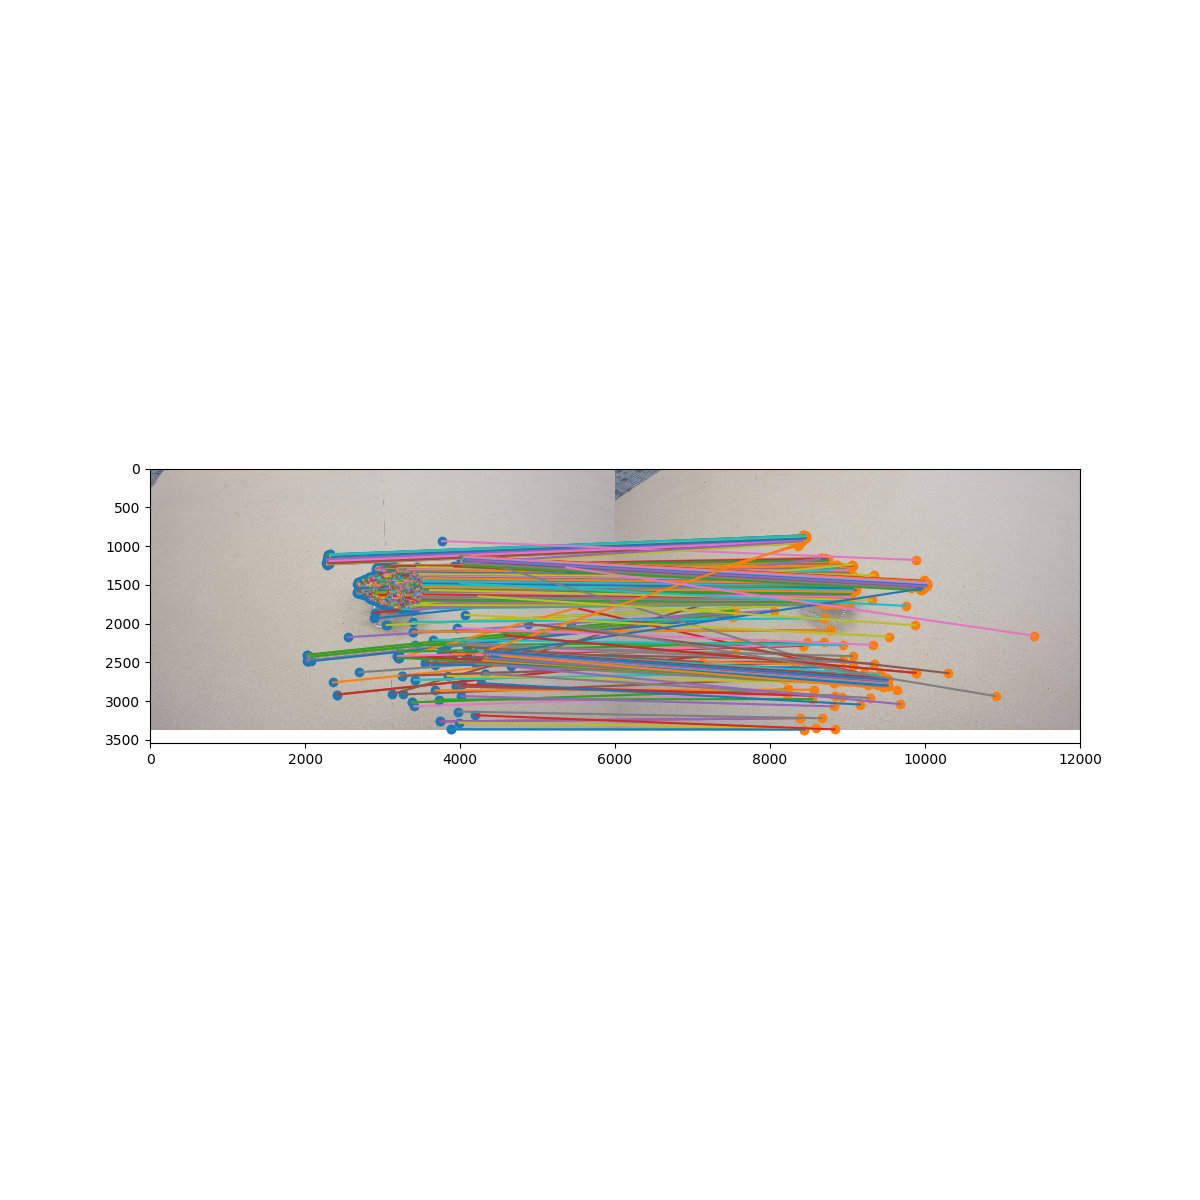

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import cv2
import piexif

I_1 = plt.imread('falcon1.JPG')
I_2 = plt.imread('falcon2.JPG')

h,w,d = I_1.shape

sift = cv2.xfeatures2d.SIFT_create()

kp1,des1 = sift.detectAndCompute(I_1,None)
kp2,des2 = sift.detectAndCompute(I_2,None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

# Apply ratio test
good = []
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        good.append(m)
    
u1 = []
u2 = []

for m in good:
    u1.append(kp1[m.queryIdx].pt)
    u2.append(kp2[m.trainIdx].pt)
    
u1 = np.array(u1)
u2 = np.array(u2)

#Make homogeneous
u1 = np.c_[u1,np.ones(u1.shape[0])]
u2 = np.c_[u2,np.ones(u2.shape[0])]


skip = 1
fig = plt.figure(figsize=(12,12))
I_new = np.zeros((h,2*w,3)).astype(int)
I_new[:,:w,:] = I_1
I_new[:,w:,:] = I_2
plt.imshow(I_new)
plt.scatter(u1[::skip,0],u1[::skip,1])
plt.scatter(u2[::skip,0]+w,u2[::skip,1])
[plt.plot([u1[0],u2[0]+w],[u1[1],u2[1]]) for u1,u2 in zip(u1[::skip],u2[::skip])]
plt.show()

There are obviously some mismatches, but hopefully we can deal with that later by filtering out outliers.  

With these correspondences in hand, we can work towards finding a relationship between the relative geometry of the cameras with which these two images were taken.  This is not as simple as finding a homography, because not only did the camera *rotate*, but it translated as well.  As such, points in the first image will not generally map to points in the second image.  Instead, points in the first image will map to *lines* in the second image.  This is easily understood by looking at the following figure:
<img src=epipolar.jpg>
If $C$ is the optical center of camera one, and $\mathbf{x}$ is the location of a point of interest on camera one's imaging plane in generalized image coordinates, then these two locations form a ray, a line which shoots out from the camera and intersects all of the places in world coordinates that will map to that location on image one's imaging plane.  What does that ray look like in image two?  It is, of course, a line (unless the camera centers are collocated).  We can write this property mathematically as
$$ 
\mathbf{E} \mathbf{x}_1 = \mathbf{l}_2,
$$
where $\mathbf{l}_2$ are the coefficients of the line in the second image, i.e.
$$
ax + by + c = \mathbf{l} \cdot \mathbf{x} = 0, 
$$
and $\mathbf{E}$ is called the *essential matrix*.  As it turns out, the essential matrix contains all of the information we need for recovering the relative geometry between two images, and in fact has the property that 
$$
\mathbf{E} = [\mathbf{t}]_\times \mathbf{R},
$$
where $\mathbf{R}$ is the rotation matrix between the two cameras and $[\mathbf{t}]_\times$ is the cross product acting on the translation vector, i.e. 
$$
[\mathbf{t}]_\times = \begin{bmatrix} 0 & -t_Z & t_Y \\
                                      t_X & 0 & -t_X \\
                                      -t_Y & t_X & 0 \end{bmatrix}.
$$                                     
Both $\mathbf{R}$ and $\mathbf{t}$ can be recovered from the essential matrix, the former exactly, and the latter up to a scale.                        

Note that the essential matrix is defined in terms of generalized image coordinates, rather than normal image coordinates, which is to say that the influence of focal lengths and camera center positions have been removed.  How do we compute these coordinates?  Recall that image coordinates are related to generalized image coordinates by 
$$
\mathbf{u} = \mathbf{K} \mathbf{x},
$$
where $\mathbf{K}$ is the so-called camera matrix
$$
\mathbf{K} = \begin{bmatrix} f & 0 & c_u \\
                             0 & f & c_v \\
                             0 & 0 & 1 \end{bmatrix}.
$$
$\mathbf{K}$ is easily invertible, so we have that

In [2]:
h,w,d = I_1.shape
exif = piexif.load('falcon1.JPG')
f = exif['Exif'][piexif.ExifIFD.FocalLengthIn35mmFilm]/36*w
cu = w//2
cv = h//2

K_cam = np.array([[f,0,cu],[0,f,cv],[0,0,1]])
K_inv = np.linalg.inv(K_cam)
x1 = u1 @ K_inv.T
x2 = u2 @ K_inv.T 
print(x1)

[[-0.24487357  0.19892279  1.        ]
 [-0.24383963  0.17894501  1.        ]
 [-0.24348343  0.17857196  1.        ]
 ...
 [ 0.46972449  0.07903476  1.        ]
 [ 0.59264868 -0.10302966  1.        ]
 [ 0.60757544  0.08436426  1.        ]]


Note that the $\mathbf{x}$ values are approximately scaled around 1, which will be numerically helpful when computing the essential matrix.  

Back to the essential matrix: how do we find it?  Recall that 
$$ 
\mathbf{E} \mathbf{x}_1 = \mathbf{l}_2.
$$
If we knew $\mathbf{l}_2$, we could back out $\mathbf{E}$.  Unfortunately, we don't.  However, because we have point correspondences, we know something almost as good: the location in image 2 of a point that falls on $\mathbf{l_2}$, which is to say that we know a point $\mathbf{x}_2$, such that 
$$
\mathbf{l}_2 \cdot \mathbf{x}_2 = 0 (=) \mathbf{x}_2^T \mathbf{l}_2,
$$
by the definition of $\mathbf{l}_2$.  Left multiplying the expression for the essential matrix by $\mathbf{x}_2^T$, we get
$$
\mathbf{x}_2^T \mathbf{E} \mathbf{x}_1 = \mathbf{x}_2^T \mathbf{l_2} = 0.
$$
If we multiply out the left side of this thing, the coefficients of $\mathbf{E}$ appear linearly (See Szeliski, eq. 7.13).  Thus, if have 8 point correspondences (as in the homography, this matrix is only defined up to scale), then we can recover the entries of $\mathbf{E}$.  In fact, there are even better algorithms which allow us to find $\mathbf{E}$ using as few as 5 point correspondences.  Note that as in the case of computing homographies, this process is sensitive to outliers: thus it is beneficial to use RANSAC or something similar to find a model that maximizes the number of inliers while discarding points that do not fit the model.  

This would be alot to code ourselves: Fortunately, OpenCV has an excellent method that will, given point correspondences, perform a 5-point algorithm for finding $\mathbf{E}$ wrapped in RANSAC for us.  Because the process is so similar to computing homographies, we will use this instead of coding it ourselves.  It can be called as follows:

In [3]:
E,inliers = cv2.findEssentialMat(x1[:,:2],x2[:,:2],np.eye(3),method=cv2.RANSAC,threshold=1e-3)
inliers = inliers.ravel().astype(bool)
print(E,inliers)

[[-0.00073388  0.11621222  0.15671148]
 [ 0.08425748  0.00707627 -0.68432839]
 [ 0.1092424   0.68884723 -0.00604564]] [ True  True  True ...  True  True  True]


In the above function call, the first two arguments are our corresponding points in generalized, non-homogeneous, camera coordinates (hence we drop the last column of ones).  The third argument is a camera matrix: in principle, we could give this function $\mathbf{u}_1, \mathbf{u}_2$ along with the camera matrix instead of $\mathbf{x}_1,\mathbf{x}_2$, but my experimentation has shown that this leads to poor results because of the ill-conditioning of the resulting linear system of equations.  Since we are providing coordinates which have already had the camera intrinsics removed, we give it the identity matrix.  The fourth argument specifies that we want to use RANSAC for outlier detection, and the threshold argument is the RANSAC outlier detection threshold: because we're in generalized coordinates, this should be on the order of 1-3 divide by the number of pixels.

The algorithm returns the computed essential matrix, as well as a mask of points which successfully passed the outlier test.  We can plot the resulting points (in camera coordinates)


<IPython.core.display.Javascript object>


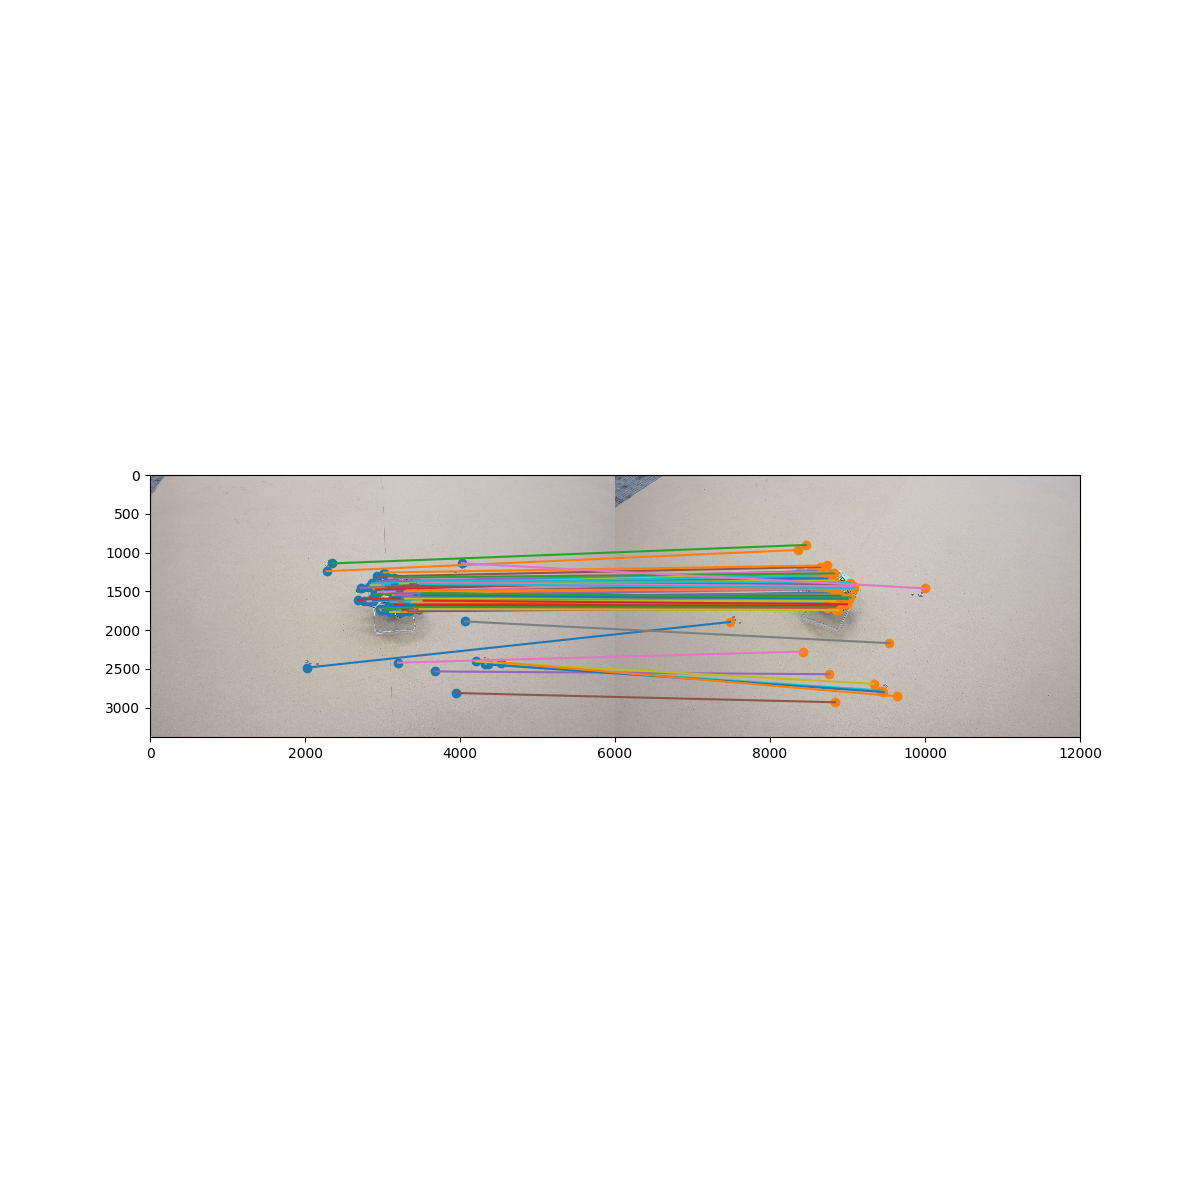

In [4]:
skip = 15
fig = plt.figure(figsize=(12,12))
I_new = np.zeros((h,2*w,3)).astype(int)
I_new[:,:w,:] = I_1
I_new[:,w:,:] = I_2
plt.imshow(I_new)
plt.scatter(u1[inliers,0][::skip],u1[inliers,1][::skip])
plt.scatter(u2[inliers,0][::skip]+w,u2[inliers,1][::skip])
[plt.plot([u1[0],u2[0]+w],[u1[1],u2[1]]) for u1,u2 in zip(u1[inliers][::skip],u2[inliers][::skip])]
plt.show()

Note that all of the weird, bad matches have been eliminated.  

Now that we have the essential matrix, we can recover the relative pose of the two cameras.  OpenCV has an easy function to do this as well, that corresponds to Szeliski Eq. 7.18 and Eq. 7.25.  

In [5]:
n_in,R,t,_ = cv2.recoverPose(E,x1[inliers,:2],x2[inliers,:2])
print(R,t)

[[ 0.88888654 -0.36598448  0.27556504]
 [ 0.36563008  0.92915589  0.05462586]
 [-0.27603509  0.05219868  0.95972909]] [[-0.96118229]
 [-0.2215638 ]
 [ 0.16443265]]


Note that the pose recovery process solves an equation that has four roots: to select the correct one, it uses the original points to enfore *chirality*, or the notion that the points in the second image should be in front of the camera.  Note also, that recoverPose only returns a single rotation and translation.  These correspond to the rotation and translation values for the second image: it is assumed that the first image has rotation given by the identity, and that the camera center is at $\mathbf{X} = \mathbf{0}$.

We can now form the camera matrices $P_1 = [\mathbf{I}| \mathbf{0}]$ and $P_2 = [\mathbf{R}|\mathbf{t}]$.

In [6]:
P_1 = np.array([[1,0,0,0],
                [0,1,0,0],
                [0,0,1,0]])
P_2 = np.hstack((R,t))
print(P_1,P_2)

[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]] [[ 0.88888654 -0.36598448  0.27556504 -0.96118229]
 [ 0.36563008  0.92915589  0.05462586 -0.2215638 ]
 [-0.27603509  0.05219868  0.95972909  0.16443265]]


Note that these are projection matrices in generalized image coordinates.  We can always get back to camera coordinates by multiplying them by the camera matrix:

In [7]:
P_1c = K_cam @ P_1
P_2c = K_cam @ P_2
print(P_1c)
print(P_2c)

[[4.000e+03 0.000e+00 3.000e+03 0.000e+00]
 [0.000e+00 4.000e+03 1.688e+03 0.000e+00]
 [0.000e+00 0.000e+00 1.000e+00 0.000e+00]]
[[ 2.72744086e+03 -1.30734187e+03  3.98144742e+03 -3.35143121e+03]
 [ 9.96573081e+02  3.80473492e+03  1.83852613e+03 -6.08692876e+02]
 [-2.76035093e-01  5.21986791e-02  9.59729090e-01  1.64432646e-01]]


**Your task is to apply this code to two images of your (judicious) choosing.  After finding the two camera matrices, instantiate two camera models with these matrices, and then use your triangulation code to find the 3D position of the points of correspondence (only the inliers!)**

## A linear solution to the triangulation problem
Note: It would seem that using LM to find the 3D location of points is sensitive to initial conditions, and it can be tricky to ensure that all points have converged, particularly since we're dealing with many point correspondences.  An alternative method for triangulating points is to formulate the problem as a linear system of equations.  To do this, we note that:
$$
\mathbf{P} \mathbf{X} = \mathbf{u}',
$$
where $\mathbf{u}'$ are the homogeneous coordinates of the point in the image.  To get back to the actual pixel values that we measure on the camera, we must divide through by the third component:
$$
u = u'/w' = \frac{P_{00}{X} + P_{01}Y + P_{02}Z + P_{03}W}{P_{20}X + P_{21}Y + P_{22}Z + P_{32}W},
$$
$$
v = v'/w' = \frac{P_{10}{X} + P_{11}Y + P_{12}Z + P_{13}W}{P_{20}X + P_{21}Y + P_{22}Z + P_{32}W}.
$$
Recall that we are looking for the components the vector $\mathbf{X}$.  In order to find a simple linear solution, these need to appear linearly.  If we multiply by the denominator in each equation, and move all terms to the left hand side, we get:
$$
P_{20}Xu + P_{21}Yu + P_{22}Zu + P_{32}Wu - P_{00}{X} - P_{01}Y - P_{02}Z - P_{03}W = 0
$$
$$
P_{20}Xv + P_{21}Yv + P_{22}Zv + P_{32}Wv - P_{10}{X} - P_{11}Y - P_{12}Z - P_{13}W = 0.
$$
Note that the components of $\mathbf{X}$ now appear linearly, and we can write this problem in the form of a linear
system of equations:
$$
\mathbf{A} \mathbf{X} = 0
$$
$$
\mathbf{A} = \begin{bmatrix} P_{20}u - P_{00} & P_{21}u - P_{01} & P_{22}u-P_{02} & P_{23}u - P_{03} \\
                             P_{20}v - P_{10} & P_{21}v - P_{11} & P_{22}v-P_{12} & P_{23}v - P_{13} \end{bmatrix}.
$$                  
Can we solve this system of equations?  No, not as stated: there are only two equations for four unknowns.  We need to more equations.  Where should these come from?  From the second image, of course!  The equation above only uses one set of $\mathbf{u}$ and one project matrix $P$, yet we have both of these things independently for the same $\mathbf{X}$ in the second image.  Thus we can write
$$
\mathbf{A} = \begin{bmatrix} P^1_{20}u_1 - P^1_{00} & P^1_{21}u_1 - P^1_{01} & P^1_{22}u_1 - P^1_{02} & P^1_{23}u_1 - P^1_{03} \\
                             P^1_{20}v_1 - P^1_{10} & P^1_{21}v_1 - P^1_{11} & P^1_{22}v_1 - P^1_{12} & P^1_{23}v_1 - P^1_{13} \\
                             P^2_{20}u_2 - P^2_{00} & P^2_{21}u_2 - P^2_{01} & P^2_{22}u_2 - P^2_{02} & P^2_{23}u_2 - P^2_{03} \\
                             P^2_{20}v_2 - P^2_{10} & P^2_{21}v_2 - P^2_{11} & P^2_{22}v_2 - P^2_{12} & P^2_{23}v_2 - P^2_{13}.\end{bmatrix}
$$                             
Which gives us $\mathbf{A} \mathbf{X} = 0$ with four equations and four unknowns.  Unfortunately, since this system is homogeneous, a viable solutions is always $\mathbf{X}=0$.  Indeed, since our measurements are not exact, this system of equations is going to have non-zero determinant, implying that the trivial solution is the *only* solution.  However, we can solve this problem approximately by finding the vector that is closest to the nullspace of $\mathbf{A}$.  This can be computed easily from the singular value decomposition:  find the the right singular vector with the associated singular value closest to zero. 

Because the above matrix has alot of indices that have to be hard-coded, it can be a little bit error-prone.  With this in mind, I've produced an implementation below that is known to work.

In [8]:
def triangulate(P0,P1,x1,x2):
    # P0,P1: projection matrices for each of two cameras/images
    # x1,x1: corresponding points in each of two images (If using P that has been scaled by K, then use camera
    # coordinates, otherwise use generalized coordinates)
    A = np.array([[P0[2,0]*x1[0] - P0[0,0], P0[2,1]*x1[0] - P0[0,1], P0[2,2]*x1[0] - P0[0,2], P0[2,3]*x1[0] - P0[0,3]],
                  [P0[2,0]*x1[1] - P0[1,0], P0[2,1]*x1[1] - P0[1,1], P0[2,2]*x1[1] - P0[1,2], P0[2,3]*x1[1] - P0[1,3]],
                  [P1[2,0]*x2[0] - P1[0,0], P1[2,1]*x2[0] - P1[0,1], P1[2,2]*x2[0] - P1[0,2], P1[2,3]*x2[0] - P1[0,3]],
                  [P1[2,0]*x2[1] - P1[1,0], P1[2,1]*x2[1] - P1[1,1], P1[2,2]*x2[1] - P1[1,2], P1[2,3]*x2[1] - P1[1,3]]])
    u,s,vt = np.linalg.svd(A)
    return vt[-1]


In [ ]:
tr = triangulate(P_1, P_2, x1[0], x2[0])
tr

In [9]:
pts = []
u1c = u1[inliers]
u2c = u2[inliers]
for x in range(len(u1c)):
    pt = triangulate(P_1c, P_2c, u1c[x], u2c[x])
    pts.append(pt)

u_out = []
v_out = []    
z_out = []
for i in range(len(pts)):
    u_out.append(pts[i][0]/pts[i][3])
    v_out.append(pts[i][1]/pts[i][3])
    z_out.append(pts[i][2]/pts[i][3])

<IPython.core.display.Javascript object>


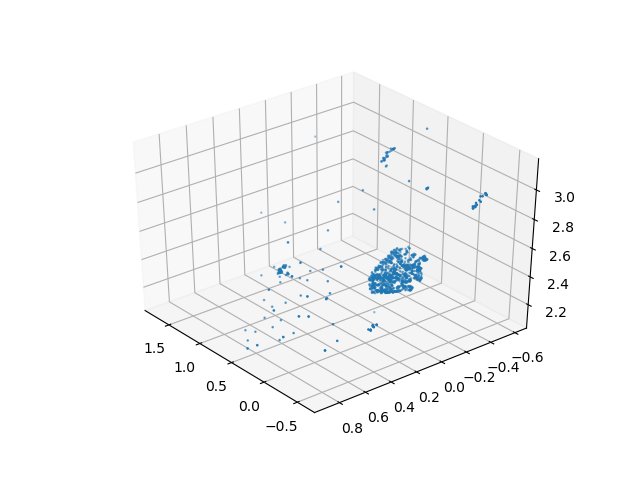

In [10]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(u_out, v_out, z_out, marker=".", s=3)
plt.show()
#for angle in range(0, 360):
#    ax.view_init(30, angle)
#    plt.draw()
#    plt.pause(.001)